In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_constrained_optimization as tfco
import scipy

To fully understand everything you may want to learn about Gaussian process first. Here the focus is on how to implement its optimization, so only a brief description is provided; feel free to check the literature.. 


Gaussian process defines a prior probability over functions. Given an arbitrary set of points $x_1,...,x_N$, the assumption is that the function values $y(x_1),...,y(x_N)$ jointly have a Gaussian distribution. The goal is to fit the parameters of this join distribution. The main trick is that the mean and covariance are defined as functions of $x$:
$$ y(x) \sim GP(m(x),k(x,x'))$$

$k(x,x')$ is a kernel function which estimates the covariance and can be defined in different ways. The one we used in this example is:

$$k(x,x') = \theta_1 exp(-\frac{||x-x'||^2}{2\theta_2})$$

And the optimization is to find out proper parameters $\theta_1$ and $\theta_2$; both of the parameters are positive, so we have two constraints.




### Dataset generation

Text(0, 0.5, '$f(x)$')

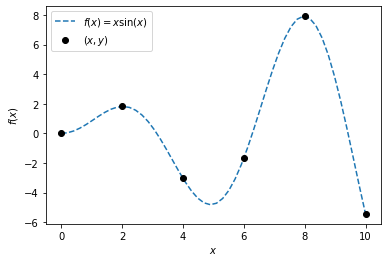

In [2]:
# Lets assume the generative process is the follwoing:
y_process = lambda x: x * np.sin(x)
x_full_range = np.linspace(start=0, stop=10, num=50).reshape(-1, 1)
# and the samples drwan from this process are:
X = np.linspace(start=0, stop=10, num=6).reshape(-1, 1)
y = np.squeeze(y_process(X)).reshape(-1, 1)

#plt.plot(np.arange(0,10,0.1))
plt.plot(x_full_range, y_process(x_full_range), linestyle='--', label=r"$f(x) =x\sin(x)$",)
plt.plot(X, y, 'ko', label=r"$(x,y)$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")


### Loss function

The loss function is negative log likelihood, so we would like to find the parameters which fit a multivariate Gaussian distribution best:
$$ -ln P(y|X,\theta_1, \theta_2) = -\frac{1}{2}(y-\mu_y)^T \Sigma_{\theta}^{-1}(y-\mu_y) + \frac{1}{2}ln|\Sigma_\theta|$$

The loss function only shows the terms which are dependent on the trainable parameters. The code is:

In [3]:
def objective():
    mean_y = lambda : np.mean(y_tr)
    y_tr_norm = y_tr - mean_y()
    Covariance = Kernel(X_tr,X_tr)
    Kernel_inv = tf.linalg.inv(Covariance)
    data_fit  = 0.5*tf.tensordot(tf.matmul(y_tr_norm, Kernel_inv, transpose_a=True), y_tr_norm, axes=1)
    complexity_penalty = 0.5*tf.math.log(tf.linalg.det(Covariance))
    return complexity_penalty + data_fit[0]

Let's make the Kernel function:

In [4]:
def Kernel(x1,x2):
    kernel = theta1 * tf.math.exp(-tf.math.squared_difference(x1,tf.transpose(x2))/2*theta2)
    return kernel

### Model fitting

In [5]:
# setting the data in TF constant form
X_tr = tf.constant(X,dtype=tf.float32)
y_tr = tf.constant(y, dtype=tf.float32)


we can make the class now

In [6]:
class FitGP(tfco.ConstrainedMinimizationProblem):
    def __init__(self, theta1, theta2):
        self.theta1 = theta1
        self.theta2 = theta2
        
    def Kernel(self,x1,x2):
        kernel = self.theta1 * tf.math.exp(-tf.math.squared_difference(x1,tf.transpose(x2))/2*self.theta2)
        return kernel
        
    def objective(self):
        mean_y = lambda : np.mean(y_tr)
        y_tr_norm = y_tr - mean_y()
        Covariance = self.Kernel(X_tr,X_tr)
        Kernel_inv = tf.linalg.inv(Covariance)
        data_fit  = 0.5*tf.tensordot(tf.matmul(y_tr_norm, Kernel_inv, transpose_a=True), y_tr_norm, axes=1)
        complexity_penalty = 0.5*tf.math.log(tf.linalg.det(Covariance))
        return complexity_penalty + data_fit[0]
    @property
    def num_constraints(self):
        return 2
    
    def constraints(self):
        constraint1 = -self.theta1
        constraint2 = -self.theta2
        return tf.stack([constraint1, constraint2])
    

In [7]:
# Initializing the parameters
theta1= tf.Variable([1], dtype=tf.float32)
theta2=tf.Variable([0.1],dtype=tf.float32)
## Instantiating the problem
problem = FitGP(theta1, theta2)

In [8]:
optim = tf.optimizers.Adagrad(1.)
optimizer = tfco.LagrangianOptimizer(optim,
                                    num_constraints=problem.num_constraints)
var_list = list(problem.trainable_variables) + optimizer.trainable_variables()

In [9]:
for ii in range(1000):
    print(f'iteration {ii}, the objective is {problem.objective()}', end="")
    print(f'theta1 ={problem.theta1.numpy()}, and theta2={problem.theta2.numpy()}')
    optimizer.minimize(problem, var_list)
    #if ii%10:
    print(f'iteration {ii}, the objective is {problem.objective()}', end="")
    print(f' theta1 ={problem.theta1.numpy()}, and theta2={problem.theta2.numpy()}')

iteration 0, the objective is [2167.1162]theta1 =[1.], and theta2=[0.1]
iteration 0, the objective is [32.585915] theta1 =[2.], and theta2=[1.1]
iteration 1, the objective is [32.585915]theta1 =[2.], and theta2=[1.1]
iteration 1, the objective is [32.497765] theta1 =[2.0063481], and theta2=[1.1001234]
iteration 2, the objective is [32.497765]theta1 =[2.0063481], and theta2=[1.1001234]
iteration 2, the objective is [32.410778] theta1 =[2.0126536], and theta2=[1.1002464]
iteration 3, the objective is [32.410778]theta1 =[2.0126536], and theta2=[1.1002464]
iteration 3, the objective is [32.32493] theta1 =[2.018917], and theta2=[1.100369]
iteration 4, the objective is [32.32493]theta1 =[2.018917], and theta2=[1.100369]
iteration 4, the objective is [32.240204] theta1 =[2.0251393], and theta2=[1.100491]
iteration 5, the objective is [32.240204]theta1 =[2.0251393], and theta2=[1.100491]
iteration 5, the objective is [32.156574] theta1 =[2.0313208], and theta2=[1.1006128]
iteration 6, the obje

iteration 61, the objective is [28.694841] theta1 =[2.3274612], and theta2=[1.1068811]
iteration 62, the objective is [28.694841]theta1 =[2.3274612], and theta2=[1.1068811]
iteration 62, the objective is [28.648462] theta1 =[2.332051], and theta2=[1.106985]
iteration 63, the objective is [28.648462]theta1 =[2.332051], and theta2=[1.106985]
iteration 63, the objective is [28.602474] theta1 =[2.3366215], and theta2=[1.1070886]
iteration 64, the objective is [28.602474]theta1 =[2.3366215], and theta2=[1.1070886]
iteration 64, the objective is [28.55687] theta1 =[2.3411727], and theta2=[1.1071919]
iteration 65, the objective is [28.55687]theta1 =[2.3411727], and theta2=[1.1071919]
iteration 65, the objective is [28.511639] theta1 =[2.3457048], and theta2=[1.107295]
iteration 66, the objective is [28.511639]theta1 =[2.3457048], and theta2=[1.107295]
iteration 66, the objective is [28.466784] theta1 =[2.350218], and theta2=[1.107398]
iteration 67, the objective is [28.466784]theta1 =[2.35021

iteration 118, the objective is [26.542297] theta1 =[2.5628731], and theta2=[1.1124706]
iteration 119, the objective is [26.542297]theta1 =[2.5628731], and theta2=[1.1124706]
iteration 119, the objective is [26.511578] theta1 =[2.5666006], and theta2=[1.1125634]
iteration 120, the objective is [26.511578]theta1 =[2.5666006], and theta2=[1.1125634]
iteration 120, the objective is [26.481047] theta1 =[2.5703163], and theta2=[1.112656]
iteration 121, the objective is [26.481047]theta1 =[2.5703163], and theta2=[1.112656]
iteration 121, the objective is [26.450708] theta1 =[2.5740204], and theta2=[1.1127485]
iteration 122, the objective is [26.450708]theta1 =[2.5740204], and theta2=[1.1127485]
iteration 122, the objective is [26.420557] theta1 =[2.577713], and theta2=[1.1128408]
iteration 123, the objective is [26.420557]theta1 =[2.577713], and theta2=[1.1128408]
iteration 123, the objective is [26.390589] theta1 =[2.581394], and theta2=[1.1129329]
iteration 124, the objective is [26.390589

iteration 174, the objective is [25.069145] theta1 =[2.7556713], and theta2=[1.1174428]
iteration 175, the objective is [25.069145]theta1 =[2.7556713], and theta2=[1.1174428]
iteration 175, the objective is [25.046663] theta1 =[2.7588544], and theta2=[1.1175278]
iteration 176, the objective is [25.046663]theta1 =[2.7588544], and theta2=[1.1175278]
iteration 176, the objective is [25.024296] theta1 =[2.7620294], and theta2=[1.1176127]
iteration 177, the objective is [25.024296]theta1 =[2.7620294], and theta2=[1.1176127]
iteration 177, the objective is [25.002035] theta1 =[2.7651966], and theta2=[1.1176975]
iteration 178, the objective is [25.002035]theta1 =[2.7651966], and theta2=[1.1176975]
iteration 178, the objective is [24.979889] theta1 =[2.7683556], and theta2=[1.1177821]
iteration 179, the objective is [24.979889]theta1 =[2.7683556], and theta2=[1.1177821]
iteration 179, the objective is [24.95785] theta1 =[2.7715068], and theta2=[1.1178666]
iteration 180, the objective is [24.95

iteration 233, the objective is [23.924875]theta1 =[2.9283578], and theta2=[1.1221938]
iteration 233, the objective is [23.907597] theta1 =[2.9311438], and theta2=[1.1222727]
iteration 234, the objective is [23.907597]theta1 =[2.9311438], and theta2=[1.1222727]
iteration 234, the objective is [23.89039] theta1 =[2.933924], and theta2=[1.1223515]
iteration 235, the objective is [23.89039]theta1 =[2.933924], and theta2=[1.1223515]
iteration 235, the objective is [23.873255] theta1 =[2.9366984], and theta2=[1.1224303]
iteration 236, the objective is [23.873255]theta1 =[2.9366984], and theta2=[1.1224303]
iteration 236, the objective is [23.856186] theta1 =[2.9394672], and theta2=[1.122509]
iteration 237, the objective is [23.856186]theta1 =[2.9394672], and theta2=[1.122509]
iteration 237, the objective is [23.83919] theta1 =[2.94223], and theta2=[1.1225876]
iteration 238, the objective is [23.83919]theta1 =[2.94223], and theta2=[1.1225876]
iteration 238, the objective is [23.822262] theta1

iteration 292, the objective is [22.99923] theta1 =[3.0861132], and theta2=[1.1267765]
iteration 293, the objective is [22.99923]theta1 =[3.0861132], and theta2=[1.1267765]
iteration 293, the objective is [22.985481] theta1 =[3.0885947], and theta2=[1.1268504]
iteration 294, the objective is [22.985481]theta1 =[3.0885947], and theta2=[1.1268504]
iteration 294, the objective is [22.971783] theta1 =[3.0910718], and theta2=[1.1269242]
iteration 295, the objective is [22.971783]theta1 =[3.0910718], and theta2=[1.1269242]
iteration 295, the objective is [22.958134] theta1 =[3.0935445], and theta2=[1.126998]
iteration 296, the objective is [22.958134]theta1 =[3.0935445], and theta2=[1.126998]
iteration 296, the objective is [22.944527] theta1 =[3.0960128], and theta2=[1.1270716]
iteration 297, the objective is [22.944527]theta1 =[3.0960128], and theta2=[1.1270716]
iteration 297, the objective is [22.93097] theta1 =[3.098477], and theta2=[1.1271453]
iteration 298, the objective is [22.93097]t

iteration 356, the objective is [22.205837] theta1 =[3.2367494], and theta2=[1.1313654]
iteration 357, the objective is [22.205837]theta1 =[3.2367494], and theta2=[1.1313654]
iteration 357, the objective is [22.19468] theta1 =[3.238982], and theta2=[1.131435]
iteration 358, the objective is [22.19468]theta1 =[3.238982], and theta2=[1.131435]
iteration 358, the objective is [22.183552] theta1 =[3.241211], and theta2=[1.1315045]
iteration 359, the objective is [22.183552]theta1 =[3.241211], and theta2=[1.1315045]
iteration 359, the objective is [22.172459] theta1 =[3.2434366], and theta2=[1.1315739]
iteration 360, the objective is [22.172459]theta1 =[3.2434366], and theta2=[1.1315739]
iteration 360, the objective is [22.161404] theta1 =[3.2456589], and theta2=[1.1316433]
iteration 361, the objective is [22.161404]theta1 =[3.2456589], and theta2=[1.1316433]
iteration 361, the objective is [22.150377] theta1 =[3.2478778], and theta2=[1.1317126]
iteration 362, the objective is [22.150377]th

iteration 420, the objective is [21.55314] theta1 =[3.3732064], and theta2=[1.1356996]
iteration 421, the objective is [21.55314]theta1 =[3.3732064], and theta2=[1.1356996]
iteration 421, the objective is [21.543837] theta1 =[3.3752422], and theta2=[1.1357656]
iteration 422, the objective is [21.543837]theta1 =[3.3752422], and theta2=[1.1357656]
iteration 422, the objective is [21.534555] theta1 =[3.3772755], and theta2=[1.1358315]
iteration 423, the objective is [21.534555]theta1 =[3.3772755], and theta2=[1.1358315]
iteration 423, the objective is [21.525301] theta1 =[3.3793058], and theta2=[1.1358973]
iteration 424, the objective is [21.525301]theta1 =[3.3793058], and theta2=[1.1358973]
iteration 424, the objective is [21.51607] theta1 =[3.3813336], and theta2=[1.1359631]
iteration 425, the objective is [21.51607]theta1 =[3.3813336], and theta2=[1.1359631]
iteration 425, the objective is [21.506863] theta1 =[3.3833585], and theta2=[1.1360288]
iteration 426, the objective is [21.50686

iteration 473, the objective is [21.091652] theta1 =[3.4775174], and theta2=[1.1391251]
iteration 474, the objective is [21.091652]theta1 =[3.4775174], and theta2=[1.1391251]
iteration 474, the objective is [21.08352] theta1 =[3.4794188], and theta2=[1.1391884]
iteration 475, the objective is [21.08352]theta1 =[3.4794188], and theta2=[1.1391884]
iteration 475, the objective is [21.075405] theta1 =[3.481318], and theta2=[1.1392517]
iteration 476, the objective is [21.075405]theta1 =[3.481318], and theta2=[1.1392517]
iteration 476, the objective is [21.06731] theta1 =[3.4832149], and theta2=[1.139315]
iteration 477, the objective is [21.06731]theta1 =[3.4832149], and theta2=[1.139315]
iteration 477, the objective is [21.059238] theta1 =[3.4851093], and theta2=[1.1393782]
iteration 478, the objective is [21.059238]theta1 =[3.4851093], and theta2=[1.1393782]
iteration 478, the objective is [21.05118] theta1 =[3.4870014], and theta2=[1.1394414]
iteration 479, the objective is [21.05118]thet

iteration 538, the objective is [20.600674] theta1 =[3.5965352], and theta2=[1.143151]
iteration 539, the objective is [20.600674]theta1 =[3.5965352], and theta2=[1.143151]
iteration 539, the objective is [20.593664] theta1 =[3.5982978], and theta2=[1.1432116]
iteration 540, the objective is [20.593664]theta1 =[3.5982978], and theta2=[1.1432116]
iteration 540, the objective is [20.58668] theta1 =[3.6000586], and theta2=[1.1432722]
iteration 541, the objective is [20.58668]theta1 =[3.6000586], and theta2=[1.1432722]
iteration 541, the objective is [20.579702] theta1 =[3.6018174], and theta2=[1.1433326]
iteration 542, the objective is [20.579702]theta1 =[3.6018174], and theta2=[1.1433326]
iteration 542, the objective is [20.572744] theta1 =[3.6035743], and theta2=[1.143393]
iteration 543, the objective is [20.572744]theta1 =[3.6035743], and theta2=[1.143393]
iteration 543, the objective is [20.5658] theta1 =[3.605329], and theta2=[1.1434535]
iteration 544, the objective is [20.5658]theta

iteration 597, the objective is [20.21178] theta1 =[3.6973507], and theta2=[1.1466582]
iteration 598, the objective is [20.21178]theta1 =[3.6973507], and theta2=[1.1466582]
iteration 598, the objective is [20.20559] theta1 =[3.6990066], and theta2=[1.1467165]
iteration 599, the objective is [20.20559]theta1 =[3.6990066], and theta2=[1.1467165]
iteration 599, the objective is [20.199408] theta1 =[3.7006605], and theta2=[1.1467748]
iteration 600, the objective is [20.199408]theta1 =[3.7006605], and theta2=[1.1467748]
iteration 600, the objective is [20.19324] theta1 =[3.7023127], and theta2=[1.1468331]
iteration 601, the objective is [20.19324]theta1 =[3.7023127], and theta2=[1.1468331]
iteration 601, the objective is [20.187084] theta1 =[3.7039633], and theta2=[1.1468912]
iteration 602, the objective is [20.187084]theta1 =[3.7039633], and theta2=[1.1468912]
iteration 602, the objective is [20.180943] theta1 =[3.7056122], and theta2=[1.1469494]
iteration 603, the objective is [20.180943]

iteration 655, the objective is [19.871826] theta1 =[3.7907214], and theta2=[1.1499845]
iteration 656, the objective is [19.871826]theta1 =[3.7907214], and theta2=[1.1499845]
iteration 656, the objective is [19.866287] theta1 =[3.792286], and theta2=[1.1500409]
iteration 657, the objective is [19.866287]theta1 =[3.792286], and theta2=[1.1500409]
iteration 657, the objective is [19.860758] theta1 =[3.793849], and theta2=[1.1500973]
iteration 658, the objective is [19.860758]theta1 =[3.793849], and theta2=[1.1500973]
iteration 658, the objective is [19.85524] theta1 =[3.7954104], and theta2=[1.1501535]
iteration 659, the objective is [19.85524]theta1 =[3.7954104], and theta2=[1.1501535]
iteration 659, the objective is [19.84973] theta1 =[3.7969704], and theta2=[1.1502098]
iteration 660, the objective is [19.84973]theta1 =[3.7969704], and theta2=[1.1502098]
iteration 660, the objective is [19.844234] theta1 =[3.798529], and theta2=[1.150266]
iteration 661, the objective is [19.844234]thet

iteration 718, the objective is [19.541641] theta1 =[3.8865352], and theta2=[1.1534754]
iteration 719, the objective is [19.541641]theta1 =[3.8865352], and theta2=[1.1534754]
iteration 719, the objective is [19.53669] theta1 =[3.888013], and theta2=[1.1535299]
iteration 720, the objective is [19.53669]theta1 =[3.888013], and theta2=[1.1535299]
iteration 720, the objective is [19.531746] theta1 =[3.8894894], and theta2=[1.1535844]
iteration 721, the objective is [19.531746]theta1 =[3.8894894], and theta2=[1.1535844]
iteration 721, the objective is [19.526812] theta1 =[3.8909647], and theta2=[1.1536387]
iteration 722, the objective is [19.526812]theta1 =[3.8909647], and theta2=[1.1536387]
iteration 722, the objective is [19.521883] theta1 =[3.8924387], and theta2=[1.1536931]
iteration 723, the objective is [19.521883]theta1 =[3.8924387], and theta2=[1.1536931]
iteration 723, the objective is [19.516964] theta1 =[3.8939114], and theta2=[1.1537474]
iteration 724, the objective is [19.51696

iteration 779, the objective is [19.254211] theta1 =[3.9744215], and theta2=[1.1567458]
iteration 780, the objective is [19.254211]theta1 =[3.9744215], and theta2=[1.1567458]
iteration 780, the objective is [19.249735] theta1 =[3.9758255], and theta2=[1.1567986]
iteration 781, the objective is [19.249735]theta1 =[3.9758255], and theta2=[1.1567986]
iteration 781, the objective is [19.245264] theta1 =[3.9772284], and theta2=[1.1568513]
iteration 782, the objective is [19.245264]theta1 =[3.9772284], and theta2=[1.1568513]
iteration 782, the objective is [19.240799] theta1 =[3.97863], and theta2=[1.156904]
iteration 783, the objective is [19.240799]theta1 =[3.97863], and theta2=[1.156904]
iteration 783, the objective is [19.236343] theta1 =[3.9800308], and theta2=[1.1569567]
iteration 784, the objective is [19.236343]theta1 =[3.9800308], and theta2=[1.1569567]
iteration 784, the objective is [19.231894] theta1 =[3.9814303], and theta2=[1.1570094]
iteration 785, the objective is [19.231894]

iteration 833, the objective is [19.022167] theta1 =[4.048662], and theta2=[1.1595587]
iteration 834, the objective is [19.022167]theta1 =[4.048662], and theta2=[1.1595587]
iteration 834, the objective is [19.018047] theta1 =[4.050008], and theta2=[1.15961]
iteration 835, the objective is [19.018047]theta1 =[4.050008], and theta2=[1.15961]
iteration 835, the objective is [19.013935] theta1 =[4.0513525], and theta2=[1.1596614]
iteration 836, the objective is [19.013935]theta1 =[4.0513525], and theta2=[1.1596614]
iteration 836, the objective is [19.009827] theta1 =[4.0526958], and theta2=[1.1597128]
iteration 837, the objective is [19.009827]theta1 =[4.0526958], and theta2=[1.1597128]
iteration 837, the objective is [19.005728] theta1 =[4.054038], and theta2=[1.1597642]
iteration 838, the objective is [19.005728]theta1 =[4.054038], and theta2=[1.1597642]
iteration 838, the objective is [19.001635] theta1 =[4.0553794], and theta2=[1.1598154]
iteration 839, the objective is [19.001635]thet

iteration 887, the objective is [18.80826] theta1 =[4.1198883], and theta2=[1.1623006]
iteration 888, the objective is [18.80826]theta1 =[4.1198883], and theta2=[1.1623006]
iteration 888, the objective is [18.804455] theta1 =[4.1211805], and theta2=[1.1623508]
iteration 889, the objective is [18.804455]theta1 =[4.1211805], and theta2=[1.1623508]
iteration 889, the objective is [18.800655] theta1 =[4.1224723], and theta2=[1.1624008]
iteration 890, the objective is [18.800655]theta1 =[4.1224723], and theta2=[1.1624008]
iteration 890, the objective is [18.796862] theta1 =[4.123763], and theta2=[1.1624509]
iteration 891, the objective is [18.796862]theta1 =[4.123763], and theta2=[1.1624509]
iteration 891, the objective is [18.793072] theta1 =[4.125053], and theta2=[1.162501]
iteration 892, the objective is [18.793072]theta1 =[4.125053], and theta2=[1.162501]
iteration 892, the objective is [18.789288] theta1 =[4.126342], and theta2=[1.162551]
iteration 893, the objective is [18.789288]thet

iteration 947, the objective is [18.589088] theta1 =[4.1958313], and theta2=[1.1652699]
iteration 948, the objective is [18.589088]theta1 =[4.1958313], and theta2=[1.1652699]
iteration 948, the objective is [18.585587] theta1 =[4.19707], and theta2=[1.1653187]
iteration 949, the objective is [18.585587]theta1 =[4.19707], and theta2=[1.1653187]
iteration 949, the objective is [18.582088] theta1 =[4.1983085], and theta2=[1.1653675]
iteration 950, the objective is [18.582088]theta1 =[4.1983085], and theta2=[1.1653675]
iteration 950, the objective is [18.578596] theta1 =[4.199546], and theta2=[1.1654162]
iteration 951, the objective is [18.578596]theta1 =[4.199546], and theta2=[1.1654162]
iteration 951, the objective is [18.575108] theta1 =[4.2007823], and theta2=[1.165465]
iteration 952, the objective is [18.575108]theta1 =[4.2007823], and theta2=[1.165465]
iteration 952, the objective is [18.571625] theta1 =[4.202018], and theta2=[1.1655138]
iteration 953, the objective is [18.571625]the

### Prediction

Gaussian process is a regression model and we can predict the mean and standard deviation for any new given point $x_{test}$. The prediction function is provided below. For more information on how it is done, please refer to literature (e.g. https://peterroelants.github.io/posts/gaussian-process-tutorial/)

In [10]:
def predict(X_tr,y_tr, X_ts, mu_tr,mu_tst, kernel_func):
    Sigma11 = kernel_func(X_tr, X_tr)
    Sigma22 = kernel_func(X_tst, X_tst)
    Sigma12 = kernel_func(X_tr, X_tst)
    solved = scipy.linalg.solve(Sigma11, Sigma12, assume_a='pos').T
    mu21 = mu_tst + solved @ (y_tr - mu_tr)
    Sigma2 = Sigma22 - (solved @ Sigma12)
    return mu21.numpy().ravel(), np.diag(Sigma2)

In [11]:
X_tst = np.linspace(start=0, stop=12, num=100).reshape(-1, 1)
X_tst = tf.constant(X_tst, dtype=tf.float32)
mu1 = mu2 = np.mean(y_tr)

In [12]:
mu21, Sigma2 = predict(X_tr,y_tr, X_tst, mu1,mu2, problem.Kernel)

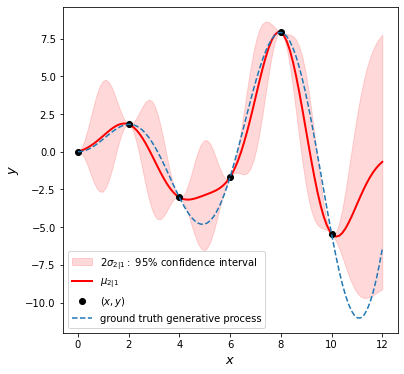

In [13]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
ax.fill_between(X_tst.numpy().ravel().flat, mu21-2*Sigma2, mu21+2*Sigma2, color='red', 
                  alpha=0.15, label='$2 \sigma_{2|1}:$ 95% confidence interval')
ax.plot(X_tst, mu21, 'r-', lw=2, label='$\mu_{2|1}$')
ax.plot(X_tr, y_tr, 'ko', linewidth=2, label='$(x, y)$')
ax.plot(X_tst, y_process(X_tst), linestyle='--', label='ground truth generative process')
ax.set_xlabel('$x$', fontsize=13)
ax.set_ylabel('$y$', fontsize=13)
ax.legend()